# Testing the method on synthetic data

Benjamin Pennell

November 27th, 2025

Max Planck Institut für Astronomie, Heidelberg

---

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

with open('config.json') as f:
    d = json.load(f)
    
import sys
import os
folder_a_path = os.path.abspath(os.path.join(os.getcwd(), d["wrapperlitepath"]))
if folder_a_path not in sys.path:
    sys.path.append(folder_a_path)

import GaiamockWrapperLite as gw

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
mdwarfs = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')

In [3]:
p_bins = [1,2,3,4.5,8]
m_bins = [0.017,0.045,0.08,0.13,0.2]

## Construct Synthetic Data

We'll start with a uniform distribution across the period, mass bins (which is quite unphysical, since they aren't even equal sized of course), and see if that can be recaptured

and we'll set the binary fraction to 20%, since it should be fairly low

In [ ]:
def get(dset, entry, binary=False):
    working_dset = dset
    if binary:
        working_dset = dset[[d["is_binary"] == True for d in dset]]
    return [w[entry] for w in working_dset]

In [ ]:
### --- ###
def random_angle():
    return float(np.random.rand()*2*np.pi)

def random_inc(): # flat in cos(i) from -1 to 1
    return float(np.acos(2*np.random.rand()-1))

def random_Tp():
    return float(np.random.rand()-0.5) # generally you get Tp in (-0.5,0.5)*period

c_funcs = gw.generate_cfuncs()

def create_synthetic_data(object_count, catalogue, binary_fraction, period_bins, mass_bins, q_lim=(0.05,0.5)):
    # period bins in logperiod, mass bins in solar masses
    binary_count = np.floor(object_count * binary_fraction)
    chosen_objects = np.random.choice(len(catalogue), object_count)
    outdata = []
    pbar = tqdm(total=object_count)
    for i in range(object_count):
        target_object = catalogue[chosen_objects[i]]
        outry = dict()
        outry["ra"], outry["dec"] = float(target_object["ra"]), float(target_object["dec"])
        outry["pmra"], outry["pmdec"] = float(target_object["pmra"]), float(target_object["pmdec"])
        outry["parallax"] = float(target_object["parallax"])
        outry["mass"] = float(target_object["mass_single"])
        outry["phot_g_mean_mag"] =  float(target_object["phot_g_mean_mag"])
        outry["bp_rp"] = float(target_object["bp_rp"])
        outry["is_binary"] = bool(i < binary_count)
        # for single stars, solution type is zero
        outry["solution_type"] = 0
        
        if i < binary_count:
            # binary, actually compute the solution type
            pdx = np.random.choice(len(period_bins)-1)
            period = 10**np.random.uniform(period_bins[pdx], period_bins[pdx+1])
            
            mdx = np.random.choice(len(mass_bins)-1)
            m2 = np.random.uniform(mass_bins[mdx], mass_bins[mdx+1])
            q = m2/outry["mass"]
            while (q < q_lim[0]) or (q_lim[1] < q):
                mdx = np.random.choice(len(mass_bins)-1)
                m2 = np.random.uniform(mass_bins[mdx], mass_bins[mdx+1])
                q = m2/outry["mass"]
            
            outry["period"] = period
            outry["m2"] = m2
            outry["q"] = q
            outry["idx"] = (pdx, mdx)
            outry["ecc"] = 0
            outry["inc"] = random_inc()
            outry["w"], outry["omega"] = random_angle(), random_angle()
            outry["Tp"] = random_Tp()*period
            t = gw.gaiamock.get_gost_one_position(outry["ra"], outry["dec"], data_release="dr3")
            
            solution_type = gw.rapid_solution_type(outry["period"], outry["q"], outry["parallax"], outry["mass"], 
                                                   outry["phot_g_mean_mag"], 1e-10, 0,
                                                   outry["inc"], outry["w"], outry["omega"], outry["Tp"],
                                                   outry["ra"], outry["dec"], outry["pmra"], outry["pmdec"], t, c_funcs)
            outry["solution_type"] = solution_type
        
        outdata.append(outry)
        pbar.update(1)
    
    return outdata

In [ ]:
synthdata = create_synthetic_data(25000, mdwarfs, 0.2, p_bins, m_bins)
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["p_bins"] = p_bins
outdata["meta"]["m_bins"] = m_bins
outdata["meta"]["metaparams"] = f"{0.2} Binary fraction, {25000} objects"
outdata["meta"]["notes"] = "2025.12.06 simplest possible synthetic dataset with a flat distribution to see if things work. Source catalogue: mdwarfs"
outdata["data"] = synthdata
with open('./data/simple_data.json', 'w') as fp:
    json.dump(outdata, fp)

In [9]:
with open('./data/simple_data.json', 'r') as fp:
    synthdata = json.load(fp)["data"]

In [44]:
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i in range(len(soltypes)):
    soltypes[i] = synthdata[i]["solution_type"] 
    
rates = [len(soltypes[soltypes == soltype])/len(synthdata)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(synthdata)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),98.308,1.34,0.132,0.076,0.144
Counts,24577.000,335.00,33.000,19.000,36.000


In [10]:
index_grid = np.zeros((4,4), dtype=int)
for tgt in synthdata:
    if tgt["is_binary"]:
        index_grid[tgt["idx"][0],tgt["idx"][1]] += 1

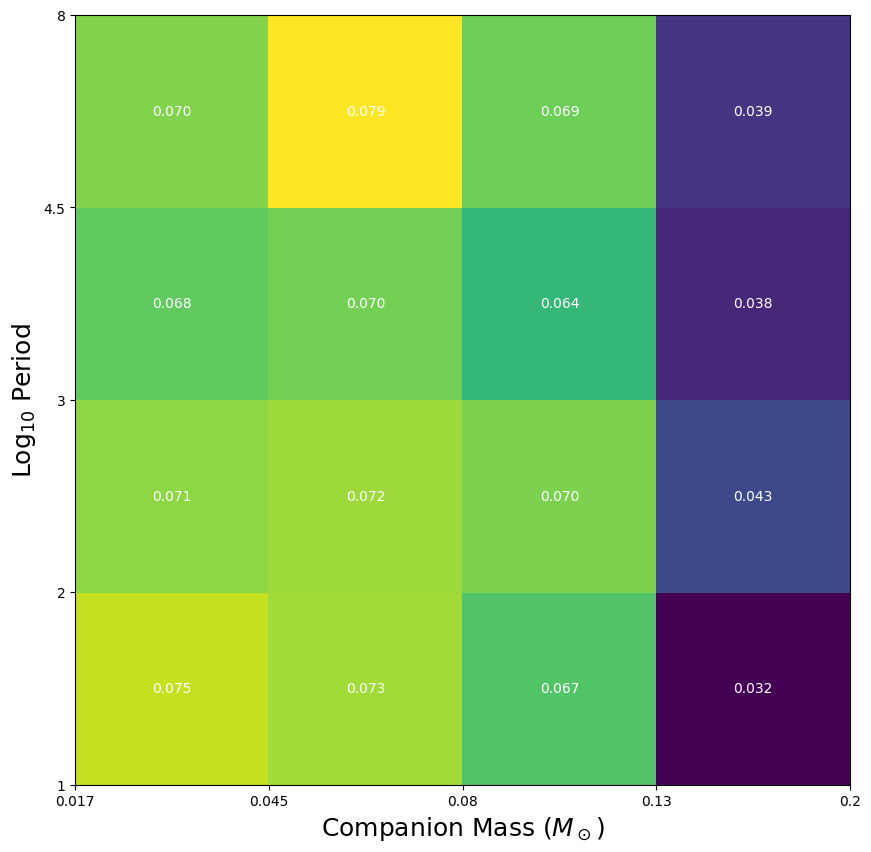

In [12]:
index_grid = index_grid / index_grid.sum()
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(index_grid, aspect="auto")

for i in range(index_grid.shape[0]):
    for j in range(index_grid.shape[1]):
        ax.text(j, i, f'{index_grid[i, j]:.3f}', ha='center', va='center', color='white')

ax.set_xticks(np.linspace(-0.5, index_grid.shape[0]-0.5, len(m_bins)))
ax.set_xticklabels(m_bins);
ax.set_yticks(np.linspace(-0.5, index_grid.shape[1]-0.5, len(p_bins)))
ax.set_yticklabels(p_bins);
ax.invert_yaxis();
ax.set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
ax.set_ylabel(r"Log$_{10}$ Period", fontsize=18);

## See if parameters are recovered

In [4]:
import Sampler
sc_cubes = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
with open('./data/binarity_testing_data_200pc.json', 'r') as fp:
    synthdata = json.load(fp)["data"]

In [5]:
synthsampler = Sampler.popsampler(sc_cubes, synthdata, [2,3,4], [0.045,0.08,0.13])

In [21]:
synthsampler.constrain_parameters(step_count=10000, nwalkers=50, cutoff=np.exp(-30))

Reducing catalogue...
Computing grids...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running markov chains...


100%|██████████| 10000/10000 [06:00<00:00, 27.70it/s]

Complete!


In [22]:
chain = synthsampler.sampler.get_chain(discard=1000, flat=True)
fb = np.median(chain[:,0])
grid = np.median(chain[:,1:], axis=0)
# grid_probs = np.zeros(16)
# grid_probs[1:] = grid
# grid_probs = grid_probs.reshape(4,4)

logits = grid - np.mean(grid) 
grid_probs = Sampler.softmax(logits)
grid_probs = grid_probs.reshape(4,4)

In [23]:
np.round(grid_probs, 3)

array([[0.017, 0.018, 0.016, 0.003],
       [0.025, 0.121, 0.202, 0.012],
       [0.022, 0.092, 0.2  , 0.022],
       [0.016, 0.017, 0.015, 0.202]])

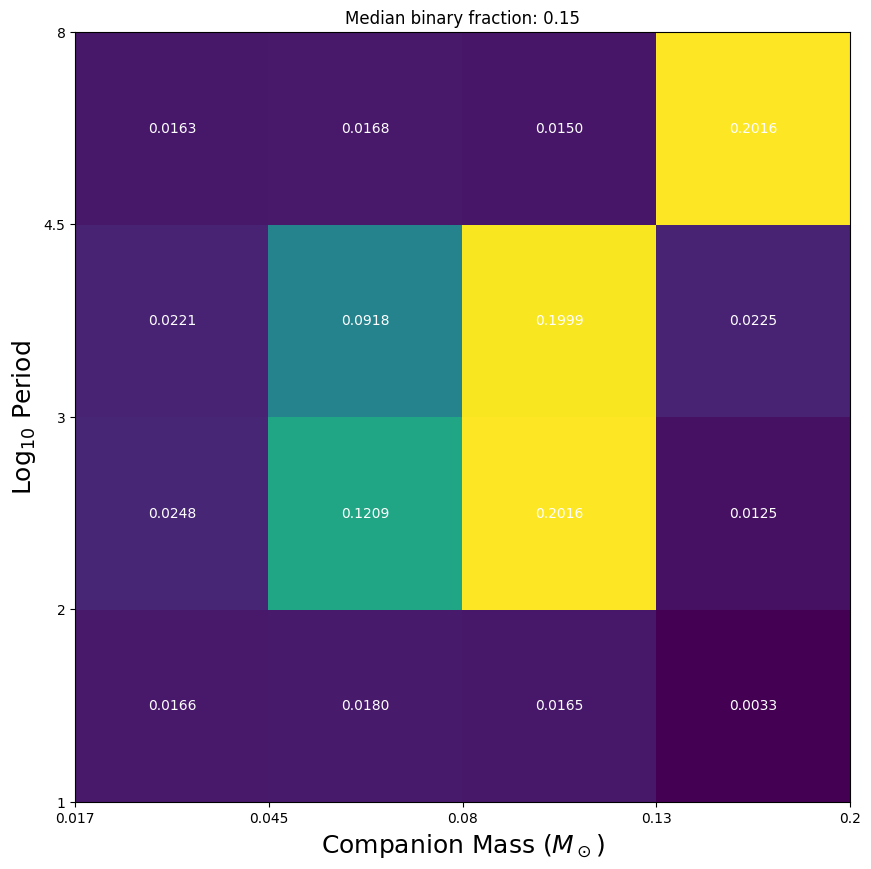

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(grid_probs, aspect="auto")

for i in range(grid_probs.shape[0]):
    for j in range(grid_probs.shape[1]):
        ax.text(j, i, f'{grid_probs[i, j]:.4f}', ha='center', va='center', color='white')

ax.set_xticks(np.linspace(-0.5, grid_probs.shape[0]-0.5, len(m_bins)))
ax.set_xticklabels(m_bins);
ax.set_yticks(np.linspace(-0.5, grid_probs.shape[1]-0.5, len(p_bins)))
ax.set_yticklabels(p_bins);
ax.invert_yaxis();
ax.set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
ax.set_ylabel(r"Log$_{10}$ Period", fontsize=18);
ax.set_title(f"Median binary fraction: {fb:.2f}");

In [10]:
working_catalogue = []
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i, target_object in enumerate(synthdata):
    # save just parallax and mass for grid conversion
    reduced_object = {
        "parallax": target_object["parallax"],
        "mass": target_object["mass"],
        "soltype_index": [0,5,7,9,12].index(target_object["solution_type"])
    }
    working_catalogue.append(reduced_object)
    
    # save just solution type for use at inference
    soltypes[i] = target_object["solution_type"] 
working_catalogue = np.array(working_catalogue)

# precompute the q-L mappings for all the objects
print("Computing grids...")
grids = np.array(Sampler.compute_grids(working_catalogue, sc_cubes, [2,3,4.5], [0.045,0.08,0.13]))

Computing grids...


  0%|          | 0/25000 [00:00<?, ?it/s]

In [15]:
ind = 35

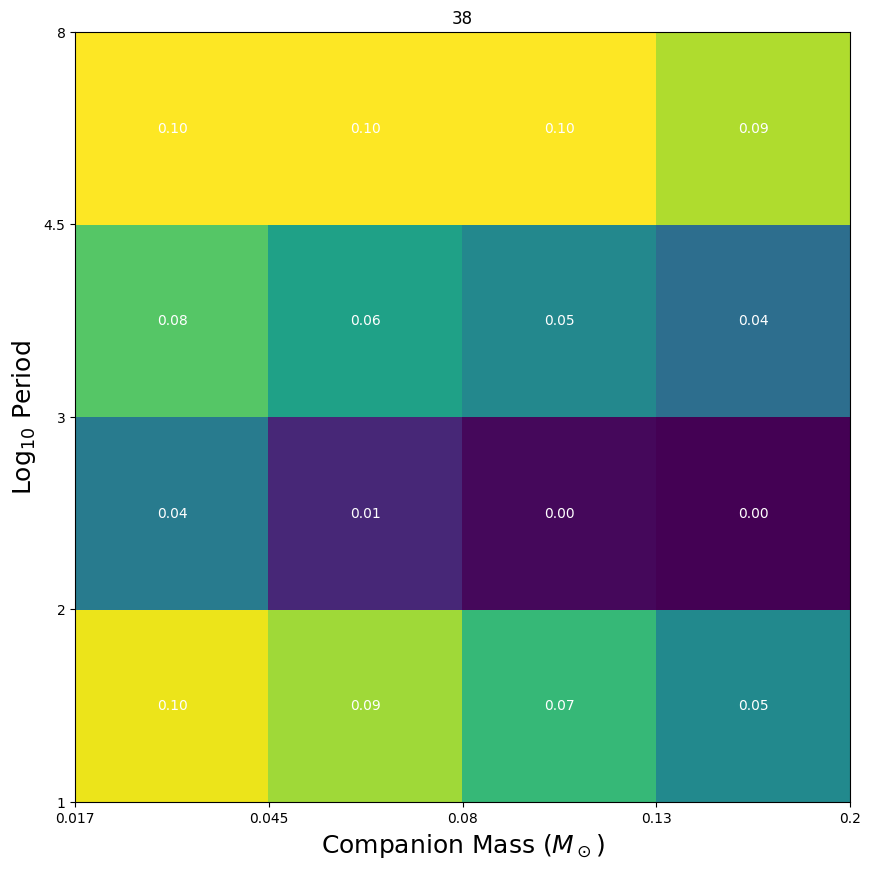

In [73]:
ind+=1
working_grid = np.mean(grids, axis=0).reshape(4,4)#*grid_probs
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(working_grid, aspect="auto")

for i in range(working_grid.shape[0]):
    for j in range(working_grid.shape[1]):
        ax.text(j, i, f'{working_grid[i, j]/working_grid.sum():.2f}', ha='center', va='center', color='white')

ax.set_xticks(np.linspace(-0.5, working_grid.shape[0]-0.5, len(m_bins)))
ax.set_xticklabels(m_bins);
ax.set_yticks(np.linspace(-0.5, working_grid.shape[1]-0.5, len(p_bins)))
ax.set_yticklabels(p_bins);
ax.invert_yaxis();
ax.set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
ax.set_ylabel(r"Log$_{10}$ Period", fontsize=18);
ax.set_title(ind);

In [9]:
pbins, mbins = [1,2,3,4,5,7,8], [0.017,0.03,0.05,0.08,0.11,0.15,0.2]

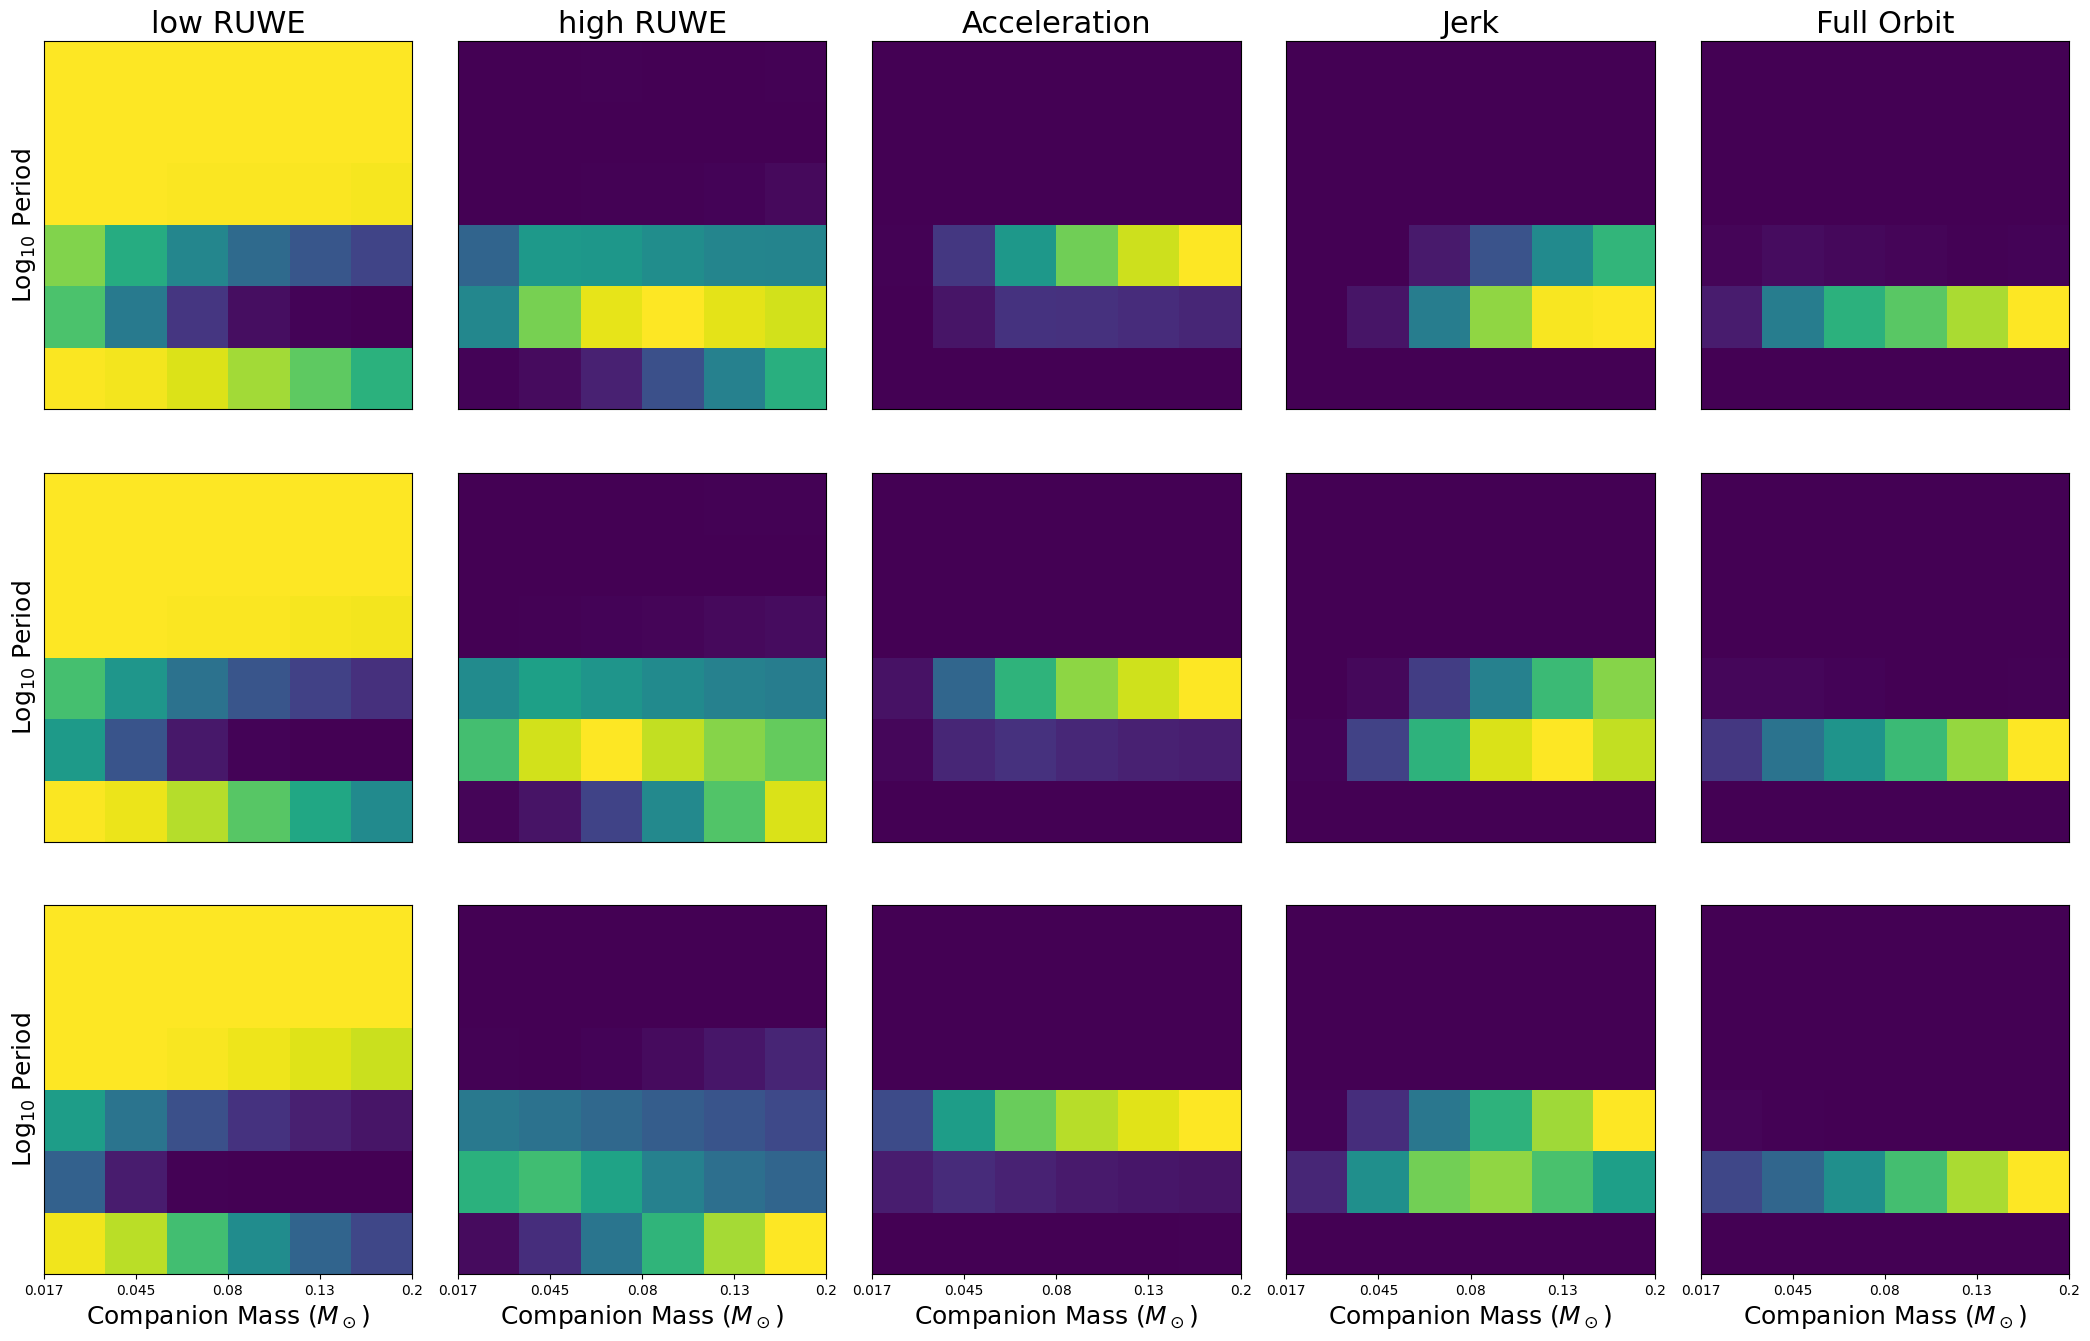

In [42]:
titles = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
plxs = [4, 5.3, 8]
fig, axs = plt.subplots(3,5, figsize=(21,14), sharey=True)

for i in range(5):
    for j in range(3):
        target_object = {
            "parallax": plxs[j],
            "mass": 0.35,
            "soltype_index": i
        }
        reduced_cube = Sampler.compute_grid(target_object, sc_cubes, [2,3,4,5,7], [0.03,0.05,0.08,0.11,0.15])
        working_object = reduced_cube
        axs[j,i].imshow(working_object, aspect="equal")

        # for i in range(working_object.shape[0]):
        #     for j in range(working_object.shape[1]):
        #         ax.text(j, i, f'{working_object[i, j]:.2f}', ha='center', va='center', color='white')
        if j == 0:
            axs[j,i].set_title(titles[i], fontsize=22);
        
        if j == 2:
            axs[j,i].set_xticks(np.linspace(-0.5, working_object.shape[0]-0.5, len(m_bins)))
            axs[j,i].set_xticklabels(m_bins);
            axs[j,i].set_xlabel(r"Companion Mass ($M_\odot$)", fontsize=18);
        else:
            axs[j,i].set_xticks([])
        
        if i == 0:
            axs[j,i].set_yticks(np.linspace(-0.5, working_object.shape[1]-0.5, len(p_bins)))
            axs[j,i].set_yticklabels(p_bins);
            axs[j,i].set_ylabel(r"Log$_{10}$ Period", fontsize=18);
        else:
            axs[j,i].set_yticks([])
            
        axs[j,i].invert_yaxis();

plt.tight_layout()

## BINARITY

### Synthetic Data

In [4]:
def get(dset, entry, binary=False):
    working_dset = dset
    if binary:
        working_dset = dset[[d["is_binary"] == True for d in dset]]
    return [w[entry] for w in working_dset]

In [5]:
### --- ###
def random_angle():
    return float(np.random.rand()*2*np.pi)

def random_inc(): # flat in cos(i) from -1 to 1
    return float(np.acos(2*np.random.rand()-1))

def random_Tp():
    return float(np.random.rand()-0.5) # generally you get Tp in (-0.5,0.5)*period

c_funcs = gw.generate_cfuncs()

def choose_value(cdf, grid):
    '''
        simply interpolate an inverse-cdf selection of the precomputed distributions
    '''
    return np.interp(np.random.uniform(np.min(cdf), np.max(cdf)), cdf, grid)

def create_synthetic_data(object_count, catalogue, binary_fraction, period_model=None, m_lim=(0.017,0.2), p_lim=(1,8), p_resolution=100, verbose=True):
    binary_count = np.floor(object_count * binary_fraction)
    chosen_objects = np.random.choice(len(catalogue), object_count)
    
    # set up period distribution
    if period_model is not None:
        mu, si = period_model
        ps = np.linspace(*p_lim, p_resolution)
        period_pdf = Sampler.gaussian(ps, mu, si)
        period_pdf = period_pdf/np.sum(period_pdf)
        period_cdf = np.cumsum(period_pdf)
    
    outdata = []
    if verbose:
        pbar = tqdm(total=object_count)
    for i in range(object_count):
        target_object = catalogue[chosen_objects[i]]
        outry = dict()
        outry["ra"], outry["dec"] = float(target_object["ra"]), float(target_object["dec"])
        outry["pmra"], outry["pmdec"] = float(target_object["pmra"]), float(target_object["pmdec"])
        outry["parallax"] = float(target_object["parallax"])
        outry["mass"] = float(target_object["mass_single"])
        outry["phot_g_mean_mag"] = float(target_object["phot_g_mean_mag"])
        outry["bp_rp"] = float(target_object["bp_rp"])
        outry["is_binary"] = bool(i < binary_count)
        # for single stars, solution type is zero
        outry["solution_type"] = 0
        
        if i < binary_count:
            # binary, actually compute the solution type
            
            if period_model is not None:
                period = 10**choose_value(period_cdf, ps) 
            else:
                period = 10**np.random.uniform(1,8)
            
            q = np.random.uniform(0.05,0.5)
            m2 = q*outry["mass"]
            while (m2 < m_lim[0]) or (m_lim[1] < m2):
                q = np.random.uniform(0.05,0.5)
                m2 = q*outry["mass"]
            
            outry["period"] = period
            outry["m2"] = m2
            outry["q"] = q
            outry["ecc"] = 0
            outry["inc"] = random_inc()
            outry["w"], outry["omega"] = random_angle(), random_angle()
            outry["Tp"] = random_Tp()*period
            t = gw.gaiamock.get_gost_one_position(outry["ra"], outry["dec"], data_release="dr3")
            
            solution_type = gw.rapid_solution_type(outry["period"], outry["q"], outry["parallax"], outry["mass"], 
                                                   outry["phot_g_mean_mag"], 1e-10, 0,
                                                   outry["inc"], outry["w"], outry["omega"], outry["Tp"],
                                                   outry["ra"], outry["dec"], outry["pmra"], outry["pmdec"], t, c_funcs)
            outry["solution_type"] = solution_type
        
        outdata.append(outry)
        if verbose:
            pbar.update(1)
    
    return outdata

In [9]:
synthdata = create_synthetic_data(5000, mdwarfs, 0.2, 5, 3)
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.2} Binary fraction, {5000} objects"
outdata["meta"]["notes"] = "2025.12.12 flat in q, T\inG(5,3). only T \in (1,8). Source catalogue: mdwarfs cut to 200pc"
outdata["data"] = synthdata
with open('./data/binarity_testing_data_200pc_5_3.json', 'w') as fp:
    json.dump(outdata, fp)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [59]:
with open('./data/binarity_testing_data_200pc.json', 'r') as fp:
    synthdata = json.load(fp)["data"]

In [15]:
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i in range(len(soltypes)):
    soltypes[i] = synthdata[i]["solution_type"] 
    
rates = [len(soltypes[soltypes == soltype])/len(synthdata)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(synthdata)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),97.98,1.7,0.24,0.0,0.08
Counts,4899.00,85.0,11.00,0.0,4.00


In [16]:
ps = []
m2s = []
qs = []
sols = []
ls = []
for target_object in synthdata:
    if target_object["is_binary"]:
        ps.append(np.log10(target_object["period"]))
        m2s.append(target_object["m2"])
        qs.append(target_object["q"])
        ls.append(Sampler.calculate_orbit_parameter(target_object["mass"], target_object["q"], target_object["parallax"]))
        sols.append(target_object["solution_type"])

ps, m2s, qs, sols, ls = np.array(ps), np.array(m2s), np.array(qs), np.array(sols), np.array(ls)

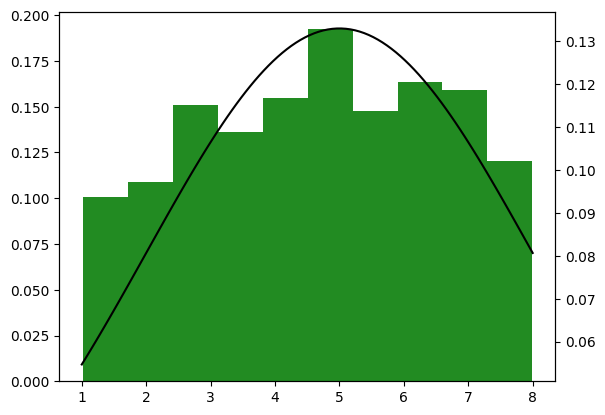

In [27]:
plt.hist(ps, bins=10, density=True, color="forestgreen");
ax = plt.twinx()
pg = np.linspace(1,8,100)
ax.plot(pg, Sampler.gaussian(pg, 5, 3), c="k");

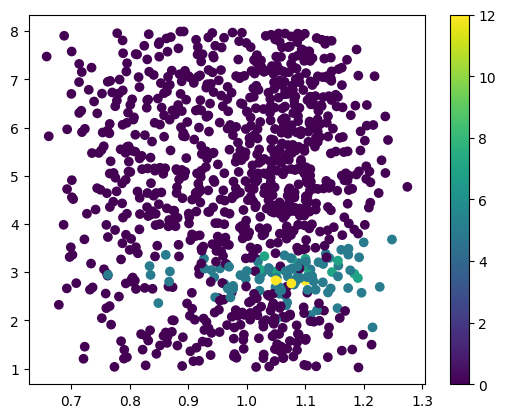

In [18]:
cb = plt.scatter(ls**(1/4), ps, c=sols);
plt.colorbar(cb);

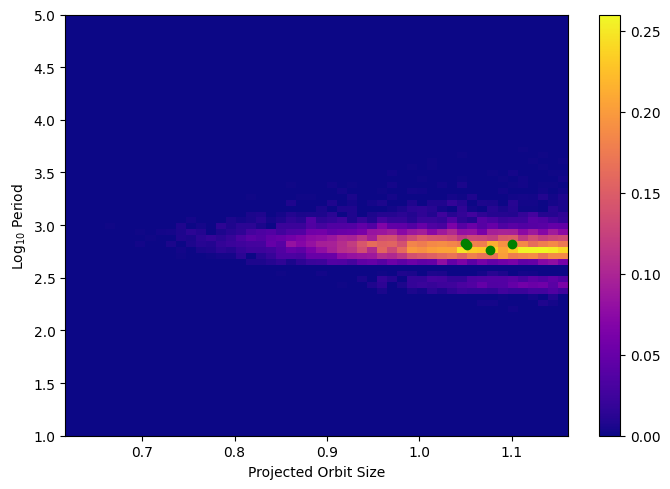

In [19]:
SOLDEX = 4
solution_type = [0,5,7,9,12][SOLDEX]
fig, ax = plt.subplots(1,1, figsize=(7,5));
plxs = list(sc_cubes["cube"].keys())
ax.set_ylabel(r"$\text{Log}_{10}$ Period");
lams = sc_cubes["meta"]["lambdas"][1]**(1/4)
xrange = np.array((lams[0], lams[-1]))
logps = np.log10(sc_cubes["meta"]["periods"])
yrange = (logps[-1], logps[0])
extent = [*xrange, *yrange]
extent = [float(e) for e in extent]

type_mask = sols == solution_type
ax.scatter(ls[type_mask]**(1/4), ps[type_mask], c="green");
cb = ax.imshow((sc_cubes["data"][plxs[0]][:,:,SOLDEX] + sc_cubes["data"][plxs[1]][:,:,SOLDEX] + sc_cubes["data"][plxs[2]][:,:,SOLDEX])/3/250, extent=extent, aspect="auto", cmap="plasma");
ax.invert_yaxis()
ax.set_xlabel("Projected Orbit Size");
fig.tight_layout()
ax.set_ylim(top=5);
plt.colorbar(cb);

### Constraining

In [10]:
import Sampler
sc_cubes = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
with open('./data/binarity_testing_data_200pc_5_3.json', 'r') as fp:
    synthdata = np.array(json.load(fp)["data"])

In [5]:
model_cube = Sampler.create_model_cube((15,15), 5, 3, p_range=(1,8))

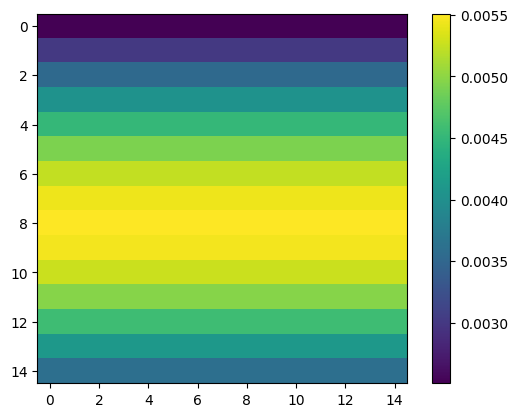

In [7]:
cb = plt.imshow(model_cube)
plt.colorbar(cb);

In [8]:
synthsampler = Sampler.popsampler(sc_cubes, synthdata, model_cube=model_cube)

In [9]:
fbs, likelihoods = synthsampler.binarity(resolution=1000, p_range=(1,8))

Reducing catalogue...
Computing grids...


  0%|          | 0/5000 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [81]:
%matplotlib inline
plt.clf()

In [69]:
%matplotlib ipympl

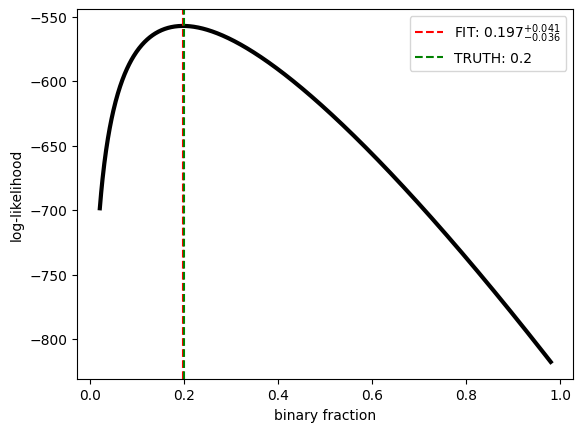

In [10]:
plt.clf();
mle, p, m  = synthsampler.fb_estimator()
plt.plot(fbs, likelihoods, c="black", linewidth=3);
plt.axvline(x=mle, c="red", linestyle="--", label=r'FIT: ${:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(mle,p,m));
plt.axvline(x=0.2, c="green", linestyle="--", label=f"TRUTH: {0.2}")
plt.xlabel("binary fraction");
plt.ylabel("log-likelihood");
plt.legend();
plt.show();

it works!

### check how good the scheme is by testing multiple models

In [43]:
def constraint_test(catalogue, sc_cubes, object_count, step_count, binary_fraction, period_model, model_resolution=(15,15)):
    print("--------------------------")
    print(f"Working with: {binary_fraction}, {period_model}")
    print("Generating data...")
    synthdata = create_synthetic_data(object_count, catalogue, binary_fraction, period_model=period_model, verbose=False)
    print("Constraining fb..")
    model_cube = Sampler.create_model_cube(model_resolution, period_model)
    synthsampler = Sampler.popsampler(sc_cubes, synthdata, model_cube=model_cube)
    synthsampler.binarity(resolution=step_count, verbose=False)
    mle, p, m = synthsampler.fb_estimator()
    print(f"Done!: {mle:.3f}+{p:.3f}-{m:.3f}")
    print("--------------------------")
    return mle, p, m

In [ ]:
results = []
for fb in [0.1,0.2,0.3]:
    results.append(constraint_test(mdwarfs, sc_cubes, 2500, 1000, fb, None))
results = np.array(results)

--------------------------
Working with: 0.1, None
Generating data...
Constraining fb..
Done!: 0.104+0.044-0.035
--------------------------
--------------------------
Working with: 0.2, None
Generating data...
Constraining fb..
Done!: 0.215+0.062-0.052
--------------------------
--------------------------
Working with: 0.3, None
Generating data...
Constraining fb..
Done!: 0.322+0.073-0.064
--------------------------


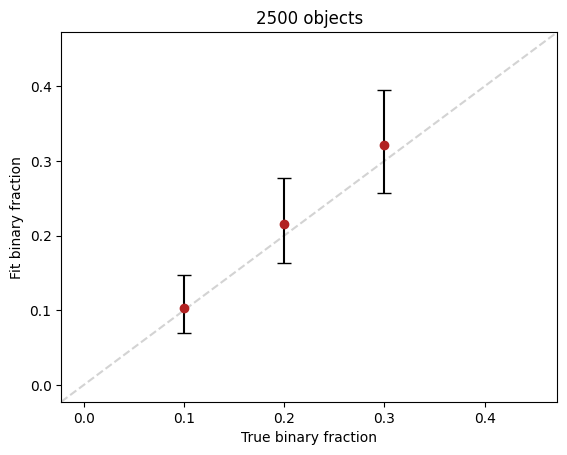

In [74]:
plt.errorbar([0.1,0.2,0.3], results[:,0], yerr=(results[:,2], results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter([0.1,0.2,0.3], results[:,0], marker='o', color='firebrick', zorder=2);
plt.axline((0,0), (0.45,0.45), linestyle="--", c="lightgrey", zorder=0);
plt.xlabel("True binary fraction");
plt.ylabel("Fit binary fraction");
plt.title("2500 objects");

In [76]:
binary_fractions = [0.1,0.2,0.3]
p_models = [(5,3),
            (1,4),
            (3,3),
            (8,3)]
constraining_results = np.zeros((len(binary_fractions), len(p_models),3))
pbar = tqdm(total=len(p_models)*len(binary_fractions))
for i in range(len(binary_fractions)):
    for j in range(len(p_models)):
        constraining_results[i,j] = constraint_test(mdwarfs, sc_cubes, 2500, 1000, binary_fractions[i], p_models[j])
        pbar.update(1)

  0%|          | 0/12 [00:00<?, ?it/s]

--------------------------
Working with: 0.1, (5, 3)
Generating data...
Constraining fb..
Done!: 0.107+0.046-0.037
--------------------------
--------------------------
Working with: 0.1, (1, 4)
Generating data...
Constraining fb..
Done!: 0.097+0.037-0.030
--------------------------
--------------------------
Working with: 0.1, (3, 3)
Generating data...
Constraining fb..
Done!: 0.112+0.041-0.033
--------------------------
--------------------------
Working with: 0.1, (8, 3)
Generating data...
Constraining fb..
Done!: 0.151+0.077-0.058
--------------------------
--------------------------
Working with: 0.2, (5, 3)
Generating data...
Constraining fb..
Done!: 0.212+0.062-0.053
--------------------------
--------------------------
Working with: 0.2, (1, 4)
Generating data...
Constraining fb..
Done!: 0.164+0.047-0.039
--------------------------
--------------------------
Working with: 0.2, (3, 3)
Generating data...
Constraining fb..
Done!: 0.224+0.055-0.047
--------------------------
------

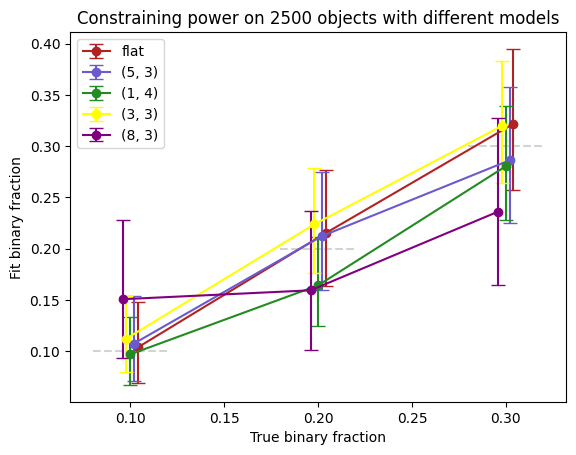

In [91]:
cols = ["firebrick", "slateblue", "forestgreen", "yellow", "purple"]
offsets = -0.002*np.array([-2,-1,0,1,2])
for i in range(len(p_models)+1):
    if i == 0:
        new_results = results
        label = "flat"
    else:
        new_results = constraining_results[:,i-1,:]
        label = p_models[i-1]
    plt.errorbar(binary_fractions+offsets[i], new_results[:,0], yerr=(new_results[:,2], new_results[:,1]), marker='o', color=cols[i], capsize=5, ecolor=cols[i], zorder=1, label=label);

for fb in binary_fractions:
    plt.plot([fb-0.02,fb+0.02], [fb, fb], linestyle="--", c="lightgrey", zorder=0);

plt.xlabel("True binary fraction");
plt.ylabel("Fit binary fraction");
plt.title("Constraining power on 2500 objects with different models");
plt.legend();

### number of object constraints

what I'd like to do here is take a large catalogue and show how the number of objects changes the uncertainties

In [21]:
import Sampler
sc_cubes = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
with open('./data/binarity_testing_data_200pc_flatp.json', 'r') as fp:
    synthdata = np.array(json.load(fp)["data"])

In [22]:
len(synthdata)

25000

In [31]:
binary_fraction = 0.2
object_count_choices = [500, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 20000, 25000]
counts = 5
step_count = 1000

In [ ]:
error = np.zeros((len(object_count_choices), counts))
uncertainties = np.zeros((len(object_count_choices), counts))
pbar = tqdm(total=len(object_count_choices)*counts)
for i, object_counts in enumerate(object_count_choices):
    for j in range(counts):
        model_cube = Sampler.create_model_cube((15,15), None, p_range=(1,8))
        synthsampler = Sampler.popsampler(sc_cubes, np.random.choice(synthdata, object_counts, replace=False), model_cube=model_cube)
        synthsampler.binarity(resolution=1000, p_range=(1,8), verbose=False)
        mle, p, m = synthsampler.fb_estimator()
        error[i, j] = abs(mle - binary_fraction)/binary_fraction # get fractional error to the fit
        uncertainties[i,j] = (p + m) / 2 # average uncertainty
        pbar.update(1)

  0%|          | 0/50 [00:00<?, ?it/s]

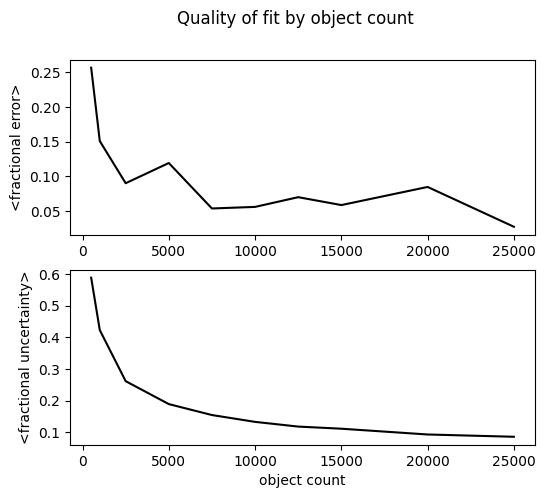

In [72]:
fig, axs = plt.subplots(2,1, figsize=(6,5))

# average error
axs[0].plot(object_count_choices, np.mean(error, axis=1), c="k")
axs[0].set_ylabel("<fractional error>");

# average uncertainty
axs[1].plot(object_count_choices, np.mean(uncertainties, axis=1)/binary_fraction, c="k")
axs[1].set_xlabel("object count");
axs[1].set_ylabel("<fractional uncertainty>");

plt.suptitle("Quality of fit by object count");

## Real data ??

In [2]:
import Sampler
sc_cubes = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
t_loaded = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')

In [3]:
memory_reduced = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(t_loaded): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    memory_reduced.append(df)

  0%|          | 0/260095 [00:00<?, ?it/s]

In [ ]:
model_cube = Sampler.create_model_cube((15,15))
synthsampler = Sampler.popsampler(sc_cubes, memory_reduced[::10], model_cube=model_cube)
fbs, likelihoods = synthsampler.binarity(resolution=1000)

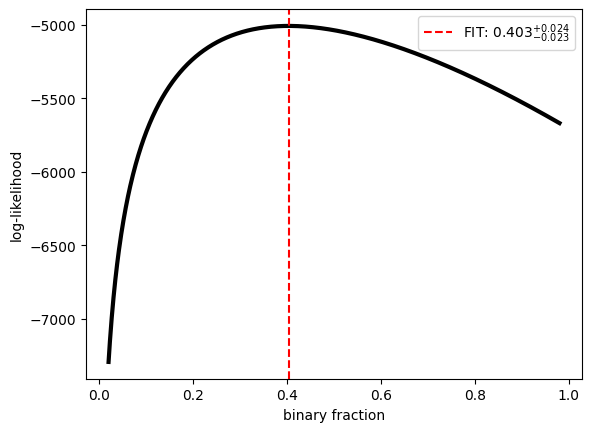

In [5]:
synthsampler.fb_likelihood()

In [27]:
model_cube = Sampler.create_model_cube((15,15), p_model=(4,3))
synthsampler = Sampler.popsampler(sc_cubes, memory_reduced, model_cube=model_cube)
fbs, likelihoods = synthsampler.binarity(resolution=1000)

Reducing catalogue...
Computing grids...


  0%|          | 0/22513 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
model_cube = Sampler.create_model_cube((15,15), p_model=(4,2))
synthsampler = Sampler.popsampler(sc_cubes, memory_reduced, model_cube=model_cube)
working_catalogue, soltypes = synthsampler.reduce_catalogue()
grids = synthsampler.assign_grids(working_catalogue, (1,8), (0.05,0.5))

  0%|          | 0/260095 [00:00<?, ?it/s]

In [20]:
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
masses = t_loaded["mass_single"]
mass_lims = np.percentile(masses, percentiles)
constraining_results_4_2 = np.zeros((len(mass_lims), 3))
for i in tqdm(range(len(percentiles))):
    temp_grids = []
    temp_catalogue = []
    for j, obj in enumerate(working_catalogue):
        obj["solution_type"] = [0,5,7,9,12][obj["soltype_index"]]
        if i == 0:
            if obj["mass"] < mass_lims[0]:
                temp_catalogue.append(obj)
                temp_grids.append(grids[j])
        else:
            if (mass_lims[i-1] < obj["mass"]) & (obj["mass"] < mass_lims[i]):
                temp_catalogue.append(obj)
                temp_grids.append(grids[j])
    synthsampler.binarity(resolution=250, grids=temp_grids, catalogue=temp_catalogue, verbose=False)
    constraining_results_4_2[i] = synthsampler.fb_estimator()

  0%|          | 0/10 [00:00<?, ?it/s]

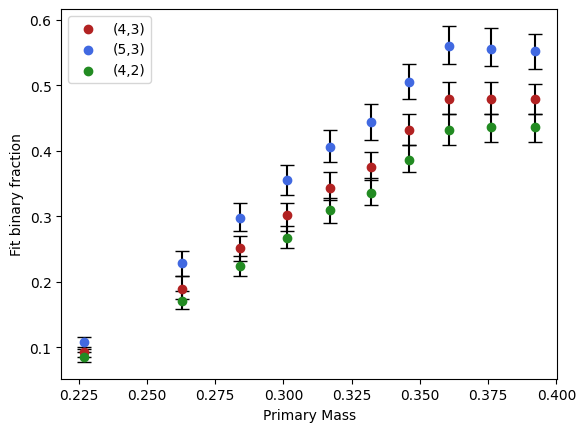

In [21]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) - 5
masses = t_loaded["mass_single"]
mass_lims = np.percentile(masses, percentiles)
plt.errorbar(mass_lims, constraining_results[:,0], yerr=(constraining_results[:,2], constraining_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results[:,0], marker='o', color='firebrick', zorder=2, label="(4,3)");

plt.errorbar(mass_lims, constraining_results_5[:,0], yerr=(constraining_results_5[:,2], constraining_results_5[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results_5[:,0], marker='o', color='royalblue', zorder=2, label="(5,3)");

plt.errorbar(mass_lims, constraining_results_4_2[:,0], yerr=(constraining_results_4_2[:,2], constraining_results_4_2[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results_4_2[:,0], marker='o', color='forestgreen', zorder=2, label="(4,2)");
plt.xlabel("Primary Mass");
plt.ylabel("Fit binary fraction");
plt.legend();

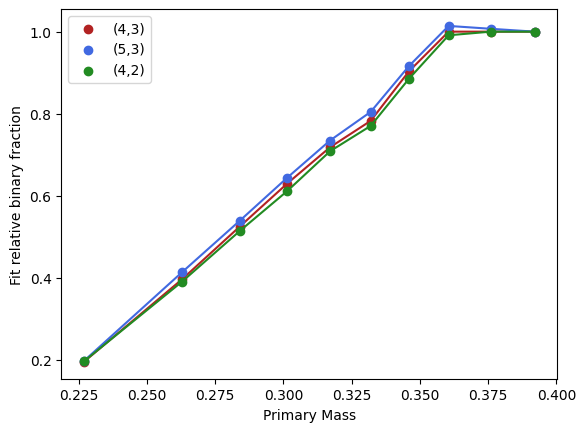

In [23]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) - 5
masses = t_loaded["mass_single"]
mass_lims = np.percentile(masses, percentiles)
plt.plot(mass_lims, constraining_results[:,0]/constraining_results[-1,0], color='firebrick')
plt.scatter(mass_lims, constraining_results[:,0]/constraining_results[-1,0], marker='o', color='firebrick', zorder=2, label="(4,3)");

plt.plot(mass_lims, constraining_results_5[:,0]/constraining_results_5[-1,0], color='royalblue')
plt.scatter(mass_lims, constraining_results_5[:,0]/constraining_results_5[-1,0], marker='o', color='royalblue', zorder=2, label="(5,3)");

plt.plot(mass_lims, constraining_results_4_2[:,0]/constraining_results_4_2[-1,0], color='forestgreen')
plt.scatter(mass_lims, constraining_results_4_2[:,0]/constraining_results_4_2[-1,0], marker='o', color='forestgreen', zorder=2, label="(4,2)");
plt.xlabel("Primary Mass");
plt.ylabel("Fit relative binary fraction");
plt.legend();

In [11]:
constraining_results[0]

array([0.09325301, 0.00771084, 0.00771084])

# Real stuff

What we're going to do here is choose some models, and show how good the code is. Here's the plots I want:
- increasing number of object $\rightarrow$ decreasing error $\rightarrow$ limit where systematics kicks in ($\gg\!25\,000$ objects)
- one particular model run across several fbs to show how it works no matter what fb is
- grid of p-models and the eccentricity models (3x3?) and the error+uncertainty (small-ish number of objects), for a single fb
    - maybe we do some kind of quote where we list a few more period models, and across several binary fractions, and quote a typical error/uncertainty
- some select models from the previous run with all the other models to show how poor the results get (for an appendix)

## Increasing object count

repeat this with a larger dataset ($100\,000$?)

In [ ]:
import Sampler
sc_cubes = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
with open('./data/binarity_testing_data_200pc_flatp.json', 'r') as fp:
    synthdata = np.array(json.load(fp)["data"])

In [ ]:
len(synthdata)

25000

In [ ]:
binary_fraction = 0.2
object_count_choices = [500, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 20000, 25000]
counts = 5
step_count = 1000

In [ ]:
error = np.zeros((len(object_count_choices), counts))
uncertainties = np.zeros((len(object_count_choices), counts))
pbar = tqdm(total=len(object_count_choices)*counts)
for i, object_counts in enumerate(object_count_choices):
    for j in range(counts):
        model_cube = Sampler.create_model_cube((15,15), None, p_range=(1,8))
        synthsampler = Sampler.popsampler(sc_cubes, np.random.choice(synthdata, object_counts, replace=False), model_cube=model_cube)
        synthsampler.binarity(resolution=1000, p_range=(1,8), verbose=False)
        mle, p, m = synthsampler.fb_estimator()
        error[i, j] = abs(mle - binary_fraction)/binary_fraction # get fractional error to the fit
        uncertainties[i,j] = (p + m) / 2 # average uncertainty
        pbar.update(1)

  0%|          | 0/50 [00:00<?, ?it/s]

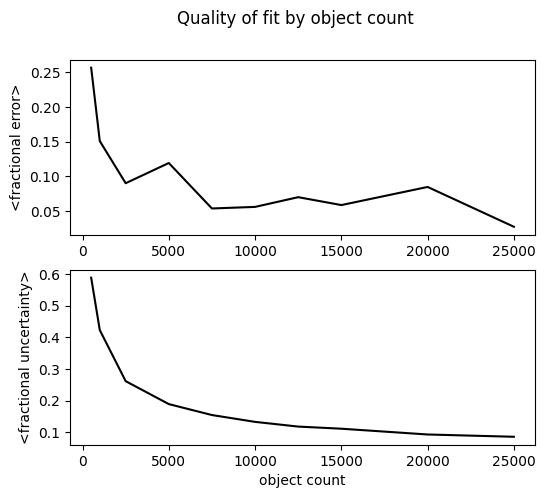

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(6,5))

# average error
axs[0].plot(object_count_choices, np.mean(error, axis=1), c="k")
axs[0].set_ylabel("<fractional error>");

# average uncertainty
axs[1].plot(object_count_choices, np.mean(uncertainties, axis=1)/binary_fraction, c="k")
axs[1].set_xlabel("object count");
axs[1].set_ylabel("<fractional uncertainty>");

plt.suptitle("Quality of fit by object count");

## Single model

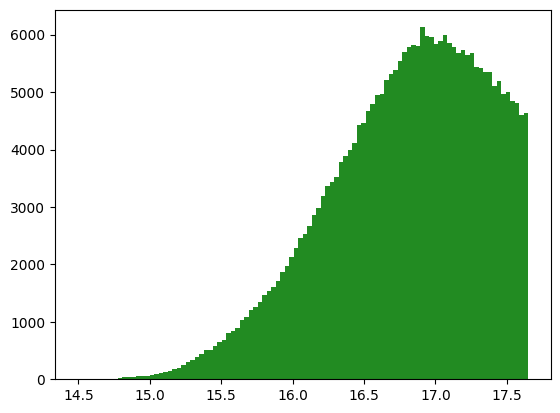

In [11]:
plt.hist(mdwarfs["phot_g_mean_mag"], bins=100, color="forestgreen");

In [5]:
binary_fraction = 0.25
p_model = (4,2)
synthdata_13 = sd.create_synthetic_data(10000, mdwarfs[::25], binary_fraction, p_model, g=13)
synthdata_17 = sd.create_synthetic_data(10000, mdwarfs[::25], binary_fraction, p_model, g=17)

Computing Binaries:   0%|          | 0/2500 [00:00<?, ?it/s]

Computing Binaries:   0%|          | 0/2500 [00:00<?, ?it/s]

In [9]:
dataset = synthdata_13
soltypes = np.array([d["solution_type"] for d in dataset])
rates = [len(dataset[soltypes == soltype])/len(dataset)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(dataset)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),90.37,4.89,2.19,1.31,1.24
Counts,9037.00,489.00,219.00,131.00,124.00


In [10]:
dataset = synthdata_17
soltypes = np.array([d["solution_type"] for d in dataset])
rates = [len(dataset[soltypes == soltype])/len(dataset)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(dataset)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),97.2,2.45,0.2,0.02,0.13
Counts,9720.0,245.00,20.0,2.00,13.00


In [4]:
binary_fraction = 0.35
p_model = (5,3)
ecc_types = ["circular"]#, "thermal", "turnover"]
gen_data = []
for ecc_type in ecc_types:
    gen_data.append(sd.create_synthetic_data(250000, mdwarfs[::10], binary_fraction, p_model, ecc_type=ecc_type))

Computing Binaries:   0%|          | 0/87500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.35} Binary fraction, {(5,3)} T distribution. circular only"
outdata["meta"]["notes"] = "2025.12.15 250k samples for all three eccentricity models"
outdata["data"] = gen_data
with open('./data/massive_samples_53.json', 'w') as fp:
    json.dump(outdata, fp)

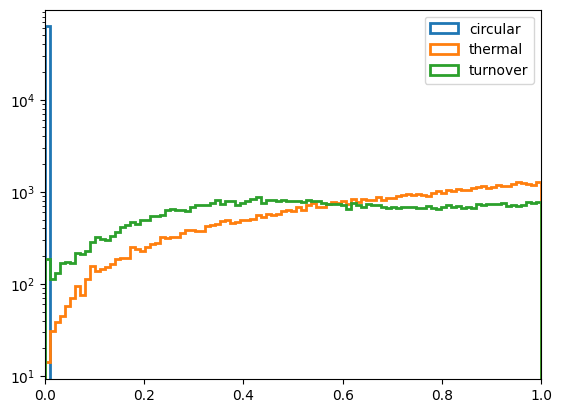

In [35]:
tbins = np.linspace(0,1,100)
for i in range(3):
    working_synthdata = np.array(synthdata[i])
    binaries = working_synthdata[[s["is_binary"] == True for s in working_synthdata]]
    plt.hist([b["ecc"] for b in binaries], bins=tbins, histtype='step', linewidth=2, label=["circular", "thermal", "turnover"][i])
plt.xlim([0,1]);
plt.legend();
plt.yscale('log')

In [2]:
with open('./data/massive_samples.json', 'r') as fp:
    synthdata = json.load(fp)["data"]

In [3]:
sc_cubes_circular = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
sc_cubes_thermal = pickle.load(open("./data/2025-12-12-200pc_mdwarf_thermal_3plx.pkl", "rb"))
sc_cubes_turnover = pickle.load(open("./data/2025-12-12-200pc_mdwarf_turnover_3plx.pkl", "rb"))

In [13]:
model_cube = Sampler.create_model_cube((25,15), p_model=(4,2))
synthsampler = Sampler.popsampler(sc_cubes_circular, synthdata[0], model_cube=model_cube)
working_catalogue, grids = synthsampler.binarity_precomputations()
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
masses = np.array([w["mass"] for w in synthdata[0]])
mass_lims = np.percentile(masses, percentiles)
constraining_results_circular = synthsampler.binarity_binned_mass(model_cube, working_catalogue, grids, mass_lims)

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
model_cube = Sampler.create_model_cube((25,15), p_model=(4,2))
synthsampler = Sampler.popsampler(sc_cubes_thermal, synthdata[1], model_cube=model_cube)
working_catalogue, grids = synthsampler.binarity_precomputations()
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
masses = np.array([w["mass"] for w in synthdata[1]])
mass_lims = np.percentile(masses, percentiles)
constraining_results_thermal = synthsampler.binarity_binned_mass(model_cube, working_catalogue, grids, mass_lims)

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
model_cube = Sampler.create_model_cube((25,15), p_model=(4,2))
synthsampler = Sampler.popsampler(sc_cubes_turnover, synthdata[2], model_cube=model_cube)
working_catalogue, grids = synthsampler.binarity_precomputations()
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
masses = np.array([w["mass"] for w in synthdata[2]])
mass_lims = np.percentile(masses, percentiles)
constraining_results_turnover = synthsampler.binarity_binned_mass(model_cube, working_catalogue, grids, mass_lims)

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

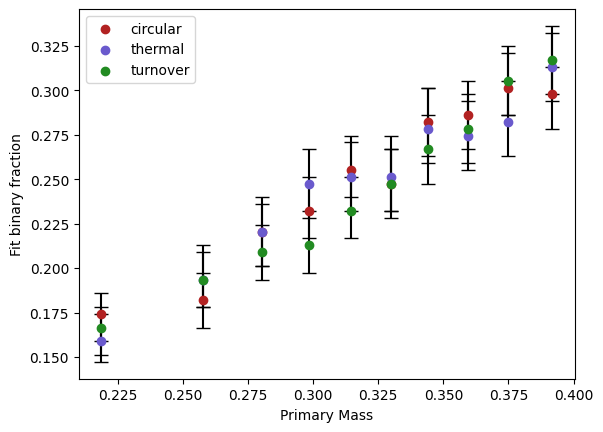

In [16]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) - 5
masses = np.array([w["mass"] for w in synthdata[0]])
mass_lims = np.percentile(masses, percentiles)
plt.errorbar(mass_lims, constraining_results_circular[:,0], yerr=(constraining_results_circular[:,2], constraining_results_circular[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results_circular[:,0], marker='o', color='firebrick', zorder=2, label="circular");

plt.errorbar(mass_lims, constraining_results_thermal[:,0], yerr=(constraining_results_thermal[:,2], constraining_results_thermal[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results_thermal[:,0], marker='o', color='slateblue', zorder=2, label="thermal");

plt.errorbar(mass_lims, constraining_results_turnover[:,0], yerr=(constraining_results_turnover[:,2], constraining_results_turnover[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, constraining_results_turnover[:,0], marker='o', color='forestgreen', zorder=2, label="turnover");
plt.xlabel("Primary Mass");
plt.ylabel("Fit binary fraction");
plt.legend();

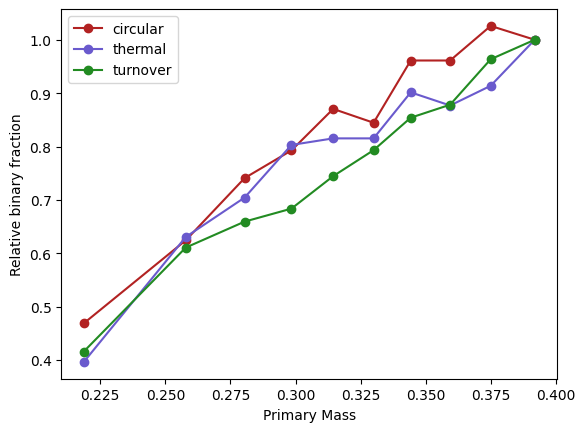

In [29]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) - 5
masses = np.array([w["mass"] for w in synthdata[0]])
mass_lims = np.percentile(masses, percentiles)
plt.plot(mass_lims, constraining_results_circular[:,0]/constraining_results_circular[-1,0], marker='o', color='firebrick', zorder=2, label="circular");
plt.plot(mass_lims, constraining_results_thermal[:,0]/constraining_results_thermal[-1,0], marker='o', color='slateblue', zorder=2, label="thermal");
plt.plot(mass_lims, constraining_results_turnover[:,0]/constraining_results_turnover[-1,0], marker='o', color='forestgreen', zorder=2, label="turnover");

plt.xlabel("Primary Mass");
plt.ylabel("Relative binary fraction");
plt.legend();

## Grid

- three eccentricity models
- three period models: (4,2), (5,2), (6,4)

In [ ]:
binary_fraction = 0.25
p_models = [(4,2), (5,3), (6,4)]
ecc_types = ["circular", "thermal", "turnover"]
gen_data = []
for p_model in p_models:
    for ecc_type in ecc_types:
        gen_data.append(sd.create_synthetic_data(10000, mdwarfs[::10], binary_fraction, p_model, ecc_type=ecc_type))

  0%|          | 0/9 [00:00<?, ?it/s]

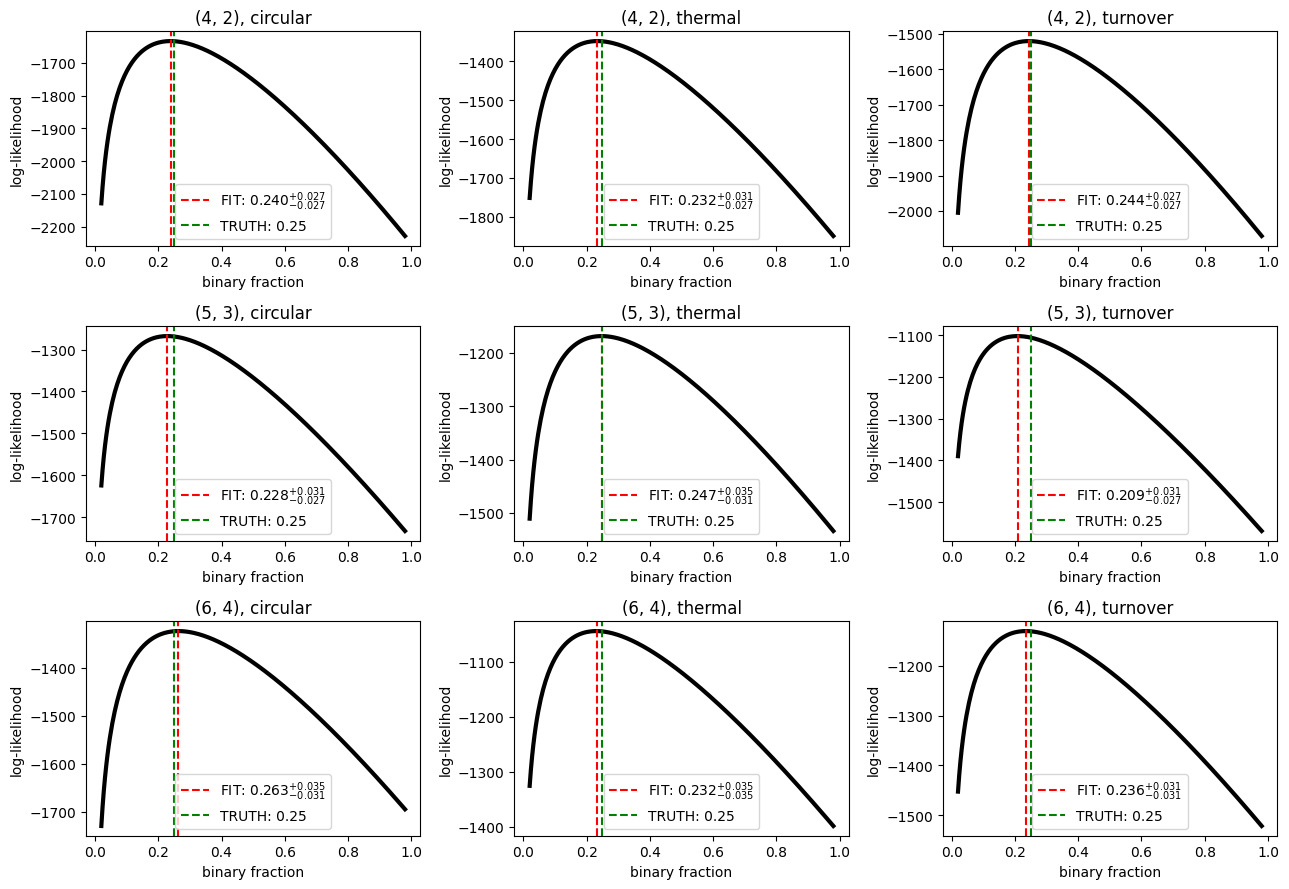

In [5]:
binary_fraction = 0.25
p_models = [(4,2), (5,3), (6,4)]
ecc_types = ["circular", "thermal", "turnover"]
errors = np.zeros(len(gen_data))
uncertainties = np.zeros(len(gen_data))

fig, axs = plt.subplots(3,3, figsize=(13,9))

counter = 0
pbar = tqdm(total=len(gen_data))
for i, p_model in enumerate(p_models):
    for j in range(len(ecc_types)):
        ax = axs[i,j]
        synthdata = gen_data[counter]
        ind = ["0","2","2"][j]
        sc_cubes = pickle.load(open(f"./data/2025-12-1{ind}-200pc_mdwarf_{ecc_types[j]}_3plx.pkl", "rb"))
        model_cube = Sampler.create_model_cube((15,15), p_model)
        synthsampler = Sampler.popsampler(sc_cubes, synthdata, model_cube=model_cube)
        synthsampler.binarity(resolution=250, verbose=False)
        mle, p, m = synthsampler.fb_estimator()
        ax.plot(synthsampler.fbs, synthsampler.likelihoods, c="black", linewidth=3);
        ax.axvline(x=mle, c="red", linestyle="--", label=r'FIT: ${:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(mle,p,m));
        ax.axvline(x=binary_fraction, c="green", linestyle="--", label=f"TRUTH: {binary_fraction}")
        ax.set_xlabel("binary fraction");
        ax.set_ylabel("log-likelihood");
        ax.set_title(f"{p_model}, {ecc_types[j]}")
        ax.legend();
        counter += 1
        pbar.update(1)
plt.tight_layout()

  0%|          | 0/9 [00:00<?, ?it/s]

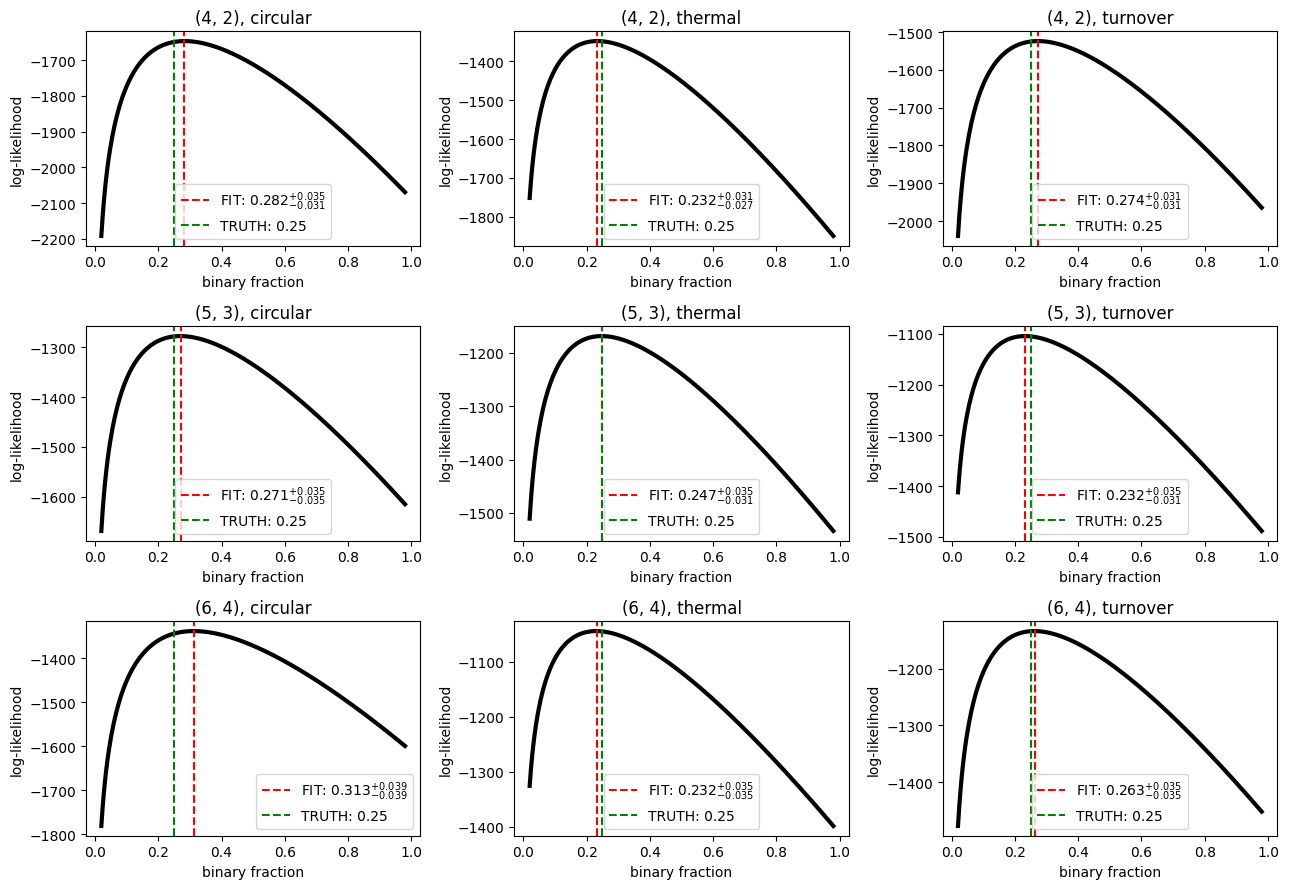

In [7]:
binary_fraction = 0.25
p_models = [(4,2), (5,3), (6,4)]
ecc_types = ["circular", "thermal", "turnover"]
errors = np.zeros(len(gen_data))
uncertainties = np.zeros(len(gen_data))

fig, axs = plt.subplots(3,3, figsize=(13,9))

counter = 0
pbar = tqdm(total=len(gen_data))
for i, p_model in enumerate(p_models):
    for j in range(len(ecc_types)):
        ax = axs[i,j]
        synthdata = gen_data[counter]
        ind = ["0","2","2"][j]
        sc_cubes = pickle.load(open(f"./data/2025-12-12-200pc_mdwarf_thermal_3plx.pkl", "rb"))
        model_cube = Sampler.create_model_cube((15,15), p_model)
        synthsampler = Sampler.popsampler(sc_cubes, synthdata, model_cube=model_cube)
        synthsampler.binarity(resolution=250, verbose=False)
        mle, p, m = synthsampler.fb_estimator()
        ax.plot(synthsampler.fbs, synthsampler.likelihoods, c="black", linewidth=3);
        ax.axvline(x=mle, c="red", linestyle="--", label=r'FIT: ${:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(mle,p,m));
        ax.axvline(x=binary_fraction, c="green", linestyle="--", label=f"TRUTH: {binary_fraction}")
        ax.set_xlabel("binary fraction");
        ax.set_ylabel("log-likelihood");
        ax.set_title(f"{p_model}, {ecc_types[j]}")
        ax.legend();
        counter += 1
        pbar.update(1)
plt.tight_layout()

  0%|          | 0/9 [00:00<?, ?it/s]

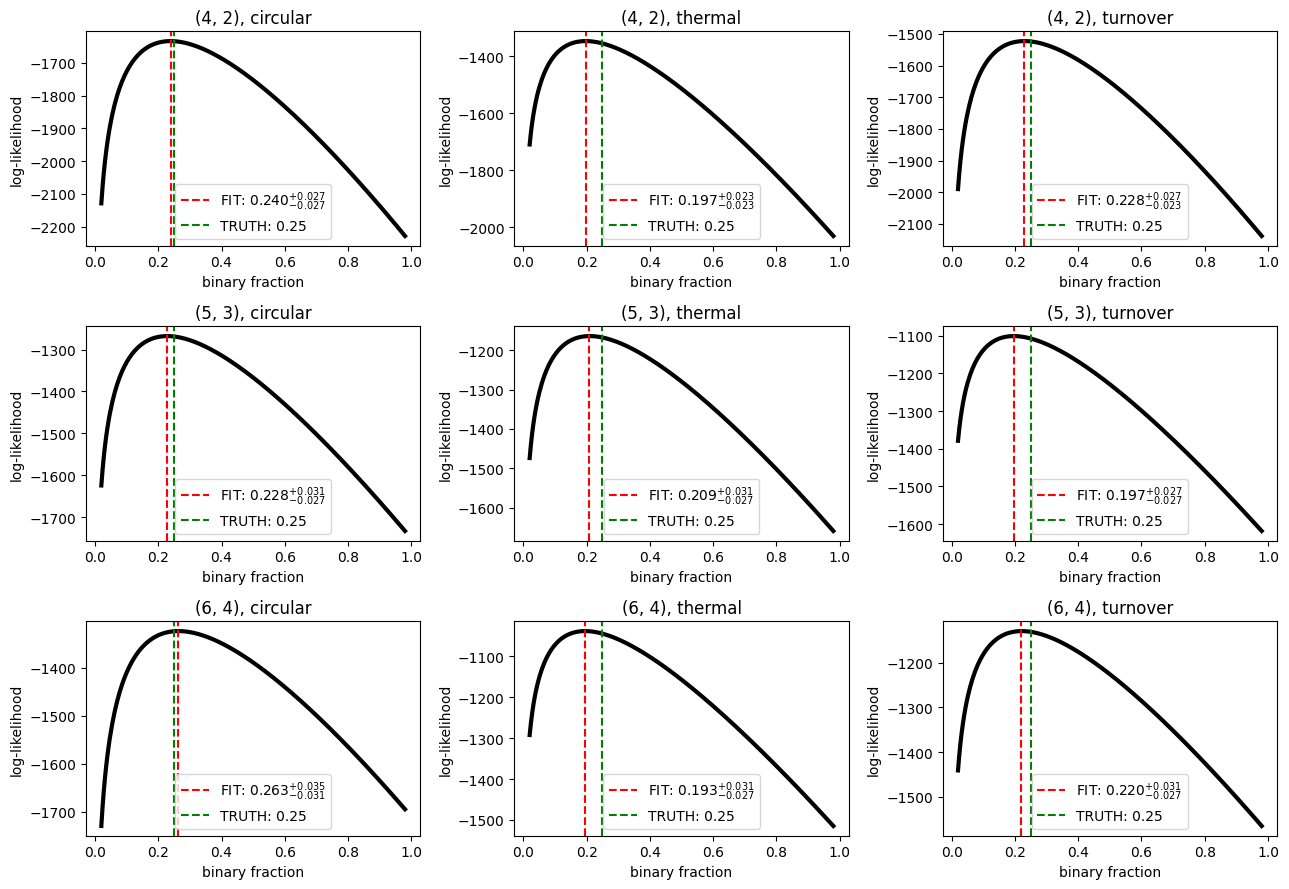

In [8]:
binary_fraction = 0.25
p_models = [(4,2), (5,3), (6,4)]
ecc_types = ["circular", "thermal", "turnover"]
errors = np.zeros(len(gen_data))
uncertainties = np.zeros(len(gen_data))

fig, axs = plt.subplots(3,3, figsize=(13,9))

counter = 0
pbar = tqdm(total=len(gen_data))
for i, p_model in enumerate(p_models):
    for j in range(len(ecc_types)):
        ax = axs[i,j]
        synthdata = gen_data[counter]
        ind = ["0","2","2"][j]
        sc_cubes = pickle.load(open(f"./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
        model_cube = Sampler.create_model_cube((15,15), p_model)
        synthsampler = Sampler.popsampler(sc_cubes, synthdata, model_cube=model_cube)
        synthsampler.binarity(resolution=250, verbose=False)
        mle, p, m = synthsampler.fb_estimator()
        ax.plot(synthsampler.fbs, synthsampler.likelihoods, c="black", linewidth=3);
        ax.axvline(x=mle, c="red", linestyle="--", label=r'FIT: ${:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(mle,p,m));
        ax.axvline(x=binary_fraction, c="green", linestyle="--", label=f"TRUTH: {binary_fraction}")
        ax.set_xlabel("binary fraction");
        ax.set_ylabel("log-likelihood");
        ax.set_title(f"{p_model}, {ecc_types[j]}")
        ax.legend();
        counter += 1
        pbar.update(1)
plt.tight_layout()

# wha

In [17]:
sc_cubes = pickle.load(open(f"./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
with open('./data/massive_samples.json', 'r') as fp:
    synthdata = json.load(fp)["data"]

In [49]:
p_range = (1,8)
q_range = (0.05,0.5)
grid_shape = (25,15)
plim = np.linspace(*p_range, grid_shape[0]+1)
qlim = np.linspace(*q_range, grid_shape[1]+1)
p_boundaries = plim[1:-1]
q_boundaries = qlim[1:-1]
target_object = {
    "parallax": 5,
    "mass": 0.4,
    "soltype_index": 4
}
da_grid = Sampler.compute_grid(target_object, sc_cubes, p_boundaries, q_boundaries, q_space=True)

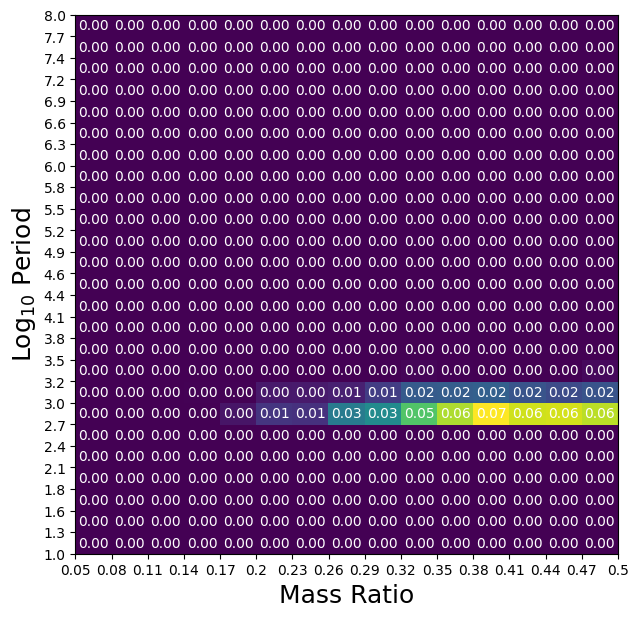

In [50]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
working_grid = da_grid
ax.imshow(working_grid, aspect="auto")

for i in range(working_grid.shape[0]):
    for j in range(working_grid.shape[1]):
        ax.text(j, i, f'{working_grid[i, j]:.2f}', ha='center', va='center', color='white')

ax.set_xticks(np.linspace(-0.5, working_grid.shape[1]-0.5, len(qlim)))
ax.set_xticklabels(np.round(qlim, 2));
ax.set_yticks(np.linspace(-0.5, working_grid.shape[0]-0.5, len(plim)))
ax.set_yticklabels(np.round(plim, 1));
ax.invert_yaxis();
ax.set_xlabel(r"Mass Ratio", fontsize=18);
ax.set_ylabel(r"Log$_{10}$ Period", fontsize=18);